# Main functions used in experiments

In [13]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [14]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
env??

Type:            WindyGridworldEnv
String form:     <WindyGridworldEnv instance>
File:            ~/Desktop/GitHub/RL_reproducibility/windy_gridworld.py
Source:         
class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(sel

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [15]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [16]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a epsilon greedy policy
        """

        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
    

    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
         
        best_actions = [i for i, j in enumerate(self.Q[obs])
                   if j == np.max(self.Q[obs])] 

        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice(best_actions)
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [17]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [18]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 4582


## Importance Sampling


In [19]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.ones((env.nS, env.nA)) * -100
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * (W * G - Q[s][a])
            
            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break
        
    return Q, episode_lens

## Performance


In [20]:
# Reproducible
seed = 10

# set other parameters
epsilon = 0.1
gamma = 1.0
num_episodes = 1000
Q = np.ones((env.nS, env.nA)) * -100
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (1000 episodes)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (1000 episodes)


100%|██████████| 1000/1000 [00:04<00:00, 222.43it/s]


In [21]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
greedy_weighted = GreedyPolicy(Q_mc_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 16
resulting episode length weighted: 17


### Plotting episode lengths during training

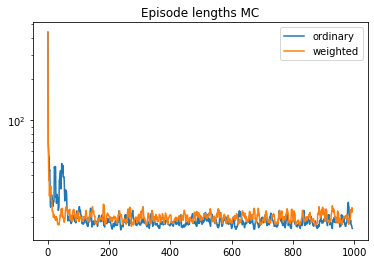

In [10]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

In [ ]:
def sarsa(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # initial state is 3,0 in the grid (according to source code)
        s = env.reset()
        a = policy.sample_action(s)
        final_state_reached = False
        
        while True:
            # new actions
            s_prime, r, final_state, _ = env.step(a)
            
            # keep track of stats
            R += r
            i += 1    
            
            # sample action at state s_prime
            a_prime = policy.sample_action(s_prime)

            # update Q 
            Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
    
            # update policy
            policy.Q = Q
            
            # if final state, terminate loop
            if final_state:
                break
        
            # update current s and a for next iteration
            s = s_prime
            a = a_prime
            
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [11]:
def sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA)) * -100
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)
            
            # Update weight
            W = (target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s_prime],[a_prime]))

            # Update Q 
            Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))
        
#     Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [ ]:
def n_step_sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, n=1, discount_factor=1.0, alpha=0.5):
    """
    n-step SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        n: number of steps
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA)) * -100
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
        
        s = defaultdict(lambda: defaultdict(float))
        a = defaultdict(lambda: defaultdict(float))
        r = defaultdict(lambda: defaultdict(float))
            
        s[0] = env.reset()
        a[0] = behavior_policy.sample_action(s[0])
        
        T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1
                
                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])
            
            tau = t - n + 1
            
            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T - 1])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]
                
                # n-step importance sampling ratio
                rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])
                
                # n-step return
                last_step_G = min([tau + n, T])
                G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
                if tau + n < T:
                    G += discount_factor**n * Q[s[tau+n]][a[tau+n]]

                # Update Q 
                Q[s[tau]][a[tau]] += alpha * rho * (G - Q[s[tau]][a[tau]])

            if tau == T - 1:
                break
                         
            t += 1

        stats.append((i, R))
        
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [ ]:
## TD weighted importance sampling

In [12]:
def sarsa_weigthed_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA)) * -100
    C = np.zeros((env.nS, env.nA))
    
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        W = 1
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
#             if (s_prime == 13):
#                 print("i: ", i, "a: ", a)
#                 print(s, s_prime)
#                 env.render()
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)
            
            
            # Update weight and C
            W = (target_policy.get_probs([s],[a]) * target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s],[a]) * behavior_policy.get_probs([s_prime],[a_prime]))
            C[s][a] += W
            if (s_prime == 13):
#                 print("C: ", C[s][a])
            # Update Q for target and behaviour policy, take W/W[s][a] = 1 if both 0. 
            if (W != 0 or C[s][a] != 0):
                Q[s][a] += W/C[s][a] * alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])
            else: 
                Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a]) 
            if (np.isnan(Q[s][a])):
#                 print("Q[s][a]: ", Q[s][a], "s, a, s', a' : ", s, a, s_prime, a_prime, "W: ", W, "C: ", C[s][a])
#             behavior_policy.Q[s][a] = Q[s][a]
#             target_policy.Q[s][a] = Q[s][a]

            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))
        
#     Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [25]:
# Reproducible
seed = 10

# set other parameters
epsilon = 0.1
gamma = 1.0
num_episodes = 1000
Q = np.ones((env.nS, env.nA)) * -100
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, sarsa_ordinary_epslengths = sarsa_ordinary_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, discount_factor=gamma)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, sarsa_weighted_epslengths = sarsa_weigthed_importance_sampling(env, 
                                                               behavioral_policy, target_policy,
                                                               num_episodes, discount_factor=gamma)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (1000 episodes)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (1000 episodes)
i:  25 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  1.2345679012345678
i:  394 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  2.4691358024691357
i:  395 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  1.2345679012345678
i:  433 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o

  0%|          | 3/1000 [00:01<05:34,  2.98it/s]

i:  137 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  15.469135802469136
i:  138 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  14.469135802469136
i:  139 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  15.469135802469136
i:  140 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  15.469135802469136
i:  10 a:  1

  1%|          | 9/1000 [00:02<04:48,  3.44it/s]

i:  185 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  22.469135802469136
i:  186 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  25.469135802469136
i:  187 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  25.469135802469136
i:  248 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  23.469135802469136
i:  249 a:  

  1%|▏         | 14/1000 [00:03<04:22,  3.76it/s]

i:  194 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  32.46913580246914
i:  345 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  33.46913580246914
i:  402 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  33.46913580246914
i:  403 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  36.46913580246914
i:  56 a:  1
12 

  2%|▏         | 19/1000 [00:04<04:08,  3.95it/s]

 o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  44.46913580246914
i:  112 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  39.46913580246914
i:  113 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  45.46913580246914
i:  114 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  45.46913580246914
i:  181 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  

  2%|▎         | 25/1000 [00:05<03:42,  4.39it/s]

i:  93 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  45.46913580246914
i:  28 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  5.0
i:  29 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  53.46913580246914
i:  30 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  53.46913580246914
i:  49 a:  1
12 13
o  o  o  o  o  

  3%|▎         | 33/1000 [00:06<03:13,  4.99it/s]

i:  20 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  6.0
i:  21 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  60.46913580246914
i:  22 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  61.46913580246914
i:  23 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  61.46913580246914
i:  36 a:  1
12 13
o  o  o  o  o  

  4%|▍         | 39/1000 [00:07<03:14,  4.94it/s]

i:  56 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  55.46913580246914
i:  165 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  56.46913580246914
i:  36 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  57.46913580246914
i:  37 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  67.46913580246914
i:  38 a:  2
13 13


  4%|▍         | 45/1000 [00:09<03:29,  4.57it/s]

i:  23 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  63.46913580246914
i:  24 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  72.46913580246914
i:  25 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  73.46913580246914
i:  26 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  73.46913580246914
i:  47 a:  3
24 13
o

  6%|▌         | 56/1000 [00:10<02:52,  5.49it/s]

i:  97 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  69.46913580246914
i:  102 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  69.46913580246914
i:  103 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  81.46913580246914
i:  104 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  82.46913580246914
i:  105 a:  2
13 

  7%|▋         | 66/1000 [00:11<02:29,  6.27it/s]

i:  16 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  77.46913580246914
i:  17 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  92.46913580246914
i:  18 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  92.46913580246914
i:  23 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  16.23456790123457
i:  24 a:  2
13 13
o

  8%|▊         | 76/1000 [00:12<02:11,  7.02it/s]

i:  175 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  84.46913580246914
i:  176 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  101.46913580246914
i:  177 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  102.46913580246914
i:  178 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  102.46913580246914
i:  179 a:  2

  8%|▊         | 85/1000 [00:13<02:01,  7.51it/s]

i:  19 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  90.46913580246914
i:  128 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  21.23456790123457
i:  129 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  107.46913580246914
i:  130 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  107.46913580246914
i:  205 a:  1
1

 10%|▉         | 96/1000 [00:14<01:49,  8.26it/s]

i:  54 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  95.46913580246914
i:  47 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  96.46913580246914
i:  48 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  113.46913580246914
i:  49 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  114.46913580246914
i:  50 a:  2
13 13

 11%|█         | 106/1000 [00:15<01:50,  8.10it/s]

i:  38 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  101.46913580246914
i:  39 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  122.46913580246914
i:  40 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  122.46913580246914
i:  75 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  24.23456790123457
i:  78 a:  1
12 1

 12%|█▏        | 115/1000 [00:16<01:54,  7.75it/s]

i:  75 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  12.0
i:  99 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  107.46913580246914
i:  100 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  130.46913580246914
i:  43 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  108.46913580246914
i:  44 a:  2
13 13
o  o  o  o

 12%|█▏        | 124/1000 [00:18<02:00,  7.28it/s]

i:  218 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  114.46913580246914
i:  219 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  137.46913580246914
i:  220 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  137.46913580246914
i:  22 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  29.23456790123457
i:  23 a:  2
1

 13%|█▎        | 132/1000 [00:19<02:01,  7.14it/s]

i:  98 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  118.46913580246914
i:  106 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  14.0
i:  107 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  143.46913580246914
i:  108 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  143.46913580246914
i:  158 a:  3
24 13
o  o  o

 14%|█▍        | 140/1000 [00:20<01:59,  7.18it/s]

i:  18 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  15.0
i:  19 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  153.46913580246914
i:  44 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  125.46913580246914
i:  45 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  154.46913580246914
i:  46 a:  2
13 13
o  o  o  o 

 15%|█▍        | 149/1000 [00:21<01:54,  7.43it/s]

 159.46913580246914
i:  68 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  159.46913580246914
i:  40 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  36.23456790123457
i:  41 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  160.46913580246914
i:  42 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  160.469135802469

 16%|█▌        | 159/1000 [00:22<01:45,  7.96it/s]

i:  79 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  135.46913580246914
i:  80 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  165.46913580246914
i:  130 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  39.23456790123457
i:  131 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  166.46913580246914
i:  28 a:  1
12

 17%|█▋        | 169/1000 [00:23<01:40,  8.29it/s]

i:  72 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  139.46913580246914
i:  73 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  174.46913580246914
i:  74 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  174.46913580246914
i:  202 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  42.23456790123457
i:  203 a:  2
13

 18%|█▊        | 178/1000 [00:25<01:45,  7.82it/s]

i:  217 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  143.46913580246914
i:  22 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  144.46913580246914
i:  23 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  180.46913580246914
i:  24 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  180.46913580246914
i:  93 a:  1
12

 19%|█▊        | 187/1000 [00:26<01:42,  7.92it/s]

i:  25 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  17.0
i:  26 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  188.46913580246914
i:  27 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  188.46913580246914
i:  46 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  149.46913580246914
i:  47 a:  2
13 13
o  o  o  o 

 20%|█▉        | 196/1000 [00:27<01:51,  7.24it/s]

i:  101 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  154.46913580246914
i:  102 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  199.46913580246914
i:  103 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  200.46913580246914
i:  104 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  200.46913580246914
i:  38 a:  1

 21%|██        | 206/1000 [00:28<01:40,  7.89it/s]

 o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  161.46913580246914
i:  64 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  209.46913580246914
i:  65 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  209.46913580246914
i:  83 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  19.0
i:  84 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  

 22%|██▏       | 221/1000 [00:29<01:25,  9.16it/s]

i:  27 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  167.46913580246914
i:  8 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  55.23456790123457
i:  9 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  219.46913580246914
i:  10 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  219.46913580246914
i:  47 a:  1
12 13


 23%|██▎       | 232/1000 [00:30<01:21,  9.37it/s]

i:  26 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  175.46913580246914
i:  29 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  176.46913580246914
i:  30 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  229.46913580246914
i:  31 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  230.46913580246914
i:  32 a:  2
13 

 25%|██▍       | 248/1000 [00:31<01:10, 10.59it/s]

i:  80 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  182.46913580246914
i:  118 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  183.46913580246914
i:  119 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  237.46913580246914
i:  120 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  238.46913580246914
i:  257 a:  1

 26%|██▌       | 260/1000 [00:32<01:07, 10.89it/s]

 o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  190.46913580246914
i:  56 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  250.46913580246914
i:  57 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  250.46913580246914
i:  69 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  67.23456790123457
i:  70 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o 

 28%|██▊       | 275/1000 [00:34<01:01, 11.70it/s]

 70.23456790123457
i:  188 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  259.46913580246917
i:  189 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  260.46913580246917
i:  190 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  260.46913580246917
i:  30 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  197.469135802

 29%|██▉       | 289/1000 [00:35<00:58, 12.21it/s]

i:  10 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  205.46913580246914
i:  46 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  75.23456790123457
i:  51 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  206.46913580246914
i:  52 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

C:  274.46913580246917
i:  53 a:  2
13 1

KeyboardInterrupt: 

 29%|██▉       | 289/1000 [00:50<00:58, 12.21it/s]

In [ ]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
greedy_weighted = GreedyPolicy(Q_mc_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

## Experiments